In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [24]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)


In [25]:
# The corresponding click values for each record
click_values = torch.tensor(df['ctr'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([58930])


In [26]:
# import numpy as np

# df_filtered['clicks_log'] = np.log1p(df_filtered['clicks'])

# sns.histplot(df_filtered['clicks_log'], bins=50, kde=True)
# plt.title('Distribution of Log-Transformed Clicks')
# plt.xlabel('Log(Clicks)')
# plt.ylabel('Frequency')
# plt.show()



# Convert to tensor
click_values = torch.tensor(df['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Z-score Normalization
mean = click_values.mean()
std = click_values.std()
click_values = (click_values - mean) / std

print(f"Updated Click Values (Z-score Normalized): {click_values[:10]}")

Updated Click Values (Z-score Normalized): tensor([ 0.1269,  0.9726,  2.9459,  1.2545, -0.7188,  0.1269,  1.2545, -0.7188,
         0.1269,  0.1269])


In [27]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['Display', 'Mobile', 
                   'Search', 'Social', 'Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_id = df[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

In [28]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)


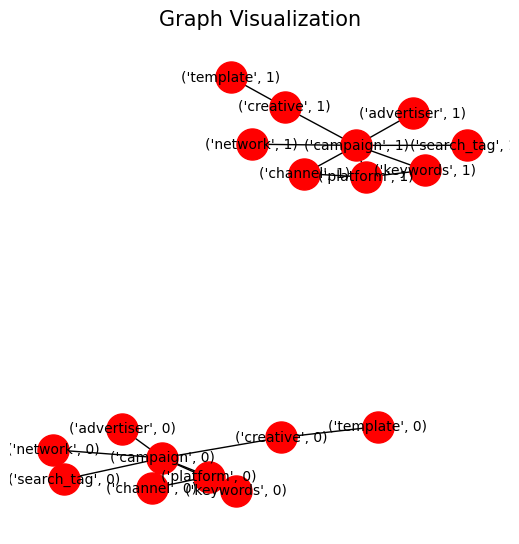

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [30]:
from torch_geometric.utils import is_undirected, contains_self_loops
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv3 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        # 🔹 Add LayerNorm for stability
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 7, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        # 🔹 Apply first convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.norm1(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.norm2(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        #🔹 Apply third convolution
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: self.norm3(x) for key, x in x_dict.items()}  # 🔹 Normalize
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], x_dict['keywords'], 
                                x_dict['search_tag'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out


In [31]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [32]:

# Initialize model
model = HeteroGCN(hidden_dim=32)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 50% every 50 epochs



num_epochs = 80
best_mse = float('inf')
patience = 50
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data (only train nodes)
    out = model(data.x_dict, data.edge_index_dict)
    train_loss = F.mse_loss(out.squeeze()[train_idx], click_values[train_idx])

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)  # No need for a separate test_data
        test_loss = F.mse_loss(test_out.squeeze()[test_idx], click_values[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train MSE: {train_loss.item():.4f}, Test MSE: {test_loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=13)
  (conv2): HeteroConv(num_relations=13)
  (conv3): HeteroConv(num_relations=13)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=224, out_features=1, bias=True)
)
Epoch 0, Train MSE: 1.7862, Test MSE: 1.0339
Epoch 1, Train MSE: 1.0299, Test MSE: 1.3081
Epoch 2, Train MSE: 1.2907, Test MSE: 1.4235
Epoch 3, Train MSE: 1.4041, Test MSE: 1.2450
Epoch 4, Train MSE: 1.2296, Test MSE: 1.0632
Epoch 5, Train MSE: 1.0542, Test MSE: 1.0233
Epoch 6, Train MSE: 1.0207, Test MSE: 1.0934
Epoch 7, Train MSE: 1.0954, Test MSE: 1.1585
Epoch 8, Train MSE: 1.1628, Test MSE: 1.1517
Epoch 9, Train MSE: 1.1559, Test MSE: 1.0907
Epoch 10, Train MSE: 1.0931, Test MSE: 1.0297
Epoch 11, Train MSE: 1.0293, Test MSE: 1.0086
Epoch 12, Train MSE: 1.0051, Test MSE: 1.0301
Epoch 13, Train MSE: 1.0240,

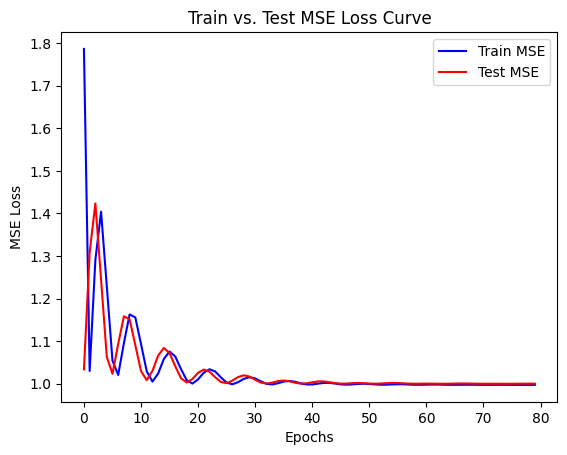

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [34]:
import torch.nn.functional as F

def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        click_values = click_values.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out[test_idx]
        click_values = click_values[test_idx]
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, click_values)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, click_values, device)
print(f"Test MSE: {mse_score:.4f}")


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_19036\1769999257.py:16: UserWarning: Using a target size (torch.Size([11786])) that is different to the input size (torch.Size([11786, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, click_values)


Test MSE: 1.0032


In [35]:
import torch
import torch.nn.functional as F

def r_squared(y_true, y_pred):
    """Calculate the R² (coefficient of determination) score."""
    # Move tensors to CPU and convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the total sum of squares and residual sum of squares
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    # Return R² score with safeguard against division by zero
    return 1 - (ss_res / (ss_tot + 1e-8))

# Ensure the model is in evaluation mode
model.eval()

# Move model and data to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
click_values = click_values.to(device)

with torch.no_grad():
    # Forward pass on the full dataset
    predictions = model(data.x_dict, data.edge_index_dict).view(-1)
    y_true = click_values.view(-1)
    
    # Apply test indices to avoid data leakage
    predictions = predictions[test_idx]
    y_true = y_true[test_idx]

    # Optional: Check for shape consistency
    assert predictions.shape == y_true.shape, f"Shape mismatch: {predictions.shape} vs {y_true.shape}"

    

# Compute R² score
r2_score = r_squared(y_true, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: 0.0007


In [36]:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).squeeze()[test_idx]

print("Actual vs Predicted Clicks:")
for actual, predicted in zip(click_values[test_idx][:10].tolist(), predictions[:10].tolist()):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


Actual vs Predicted Clicks:
Actual: -1.2826, Predicted: -0.0401
Actual: -0.1550, Predicted: -0.0014
Actual: -1.5645, Predicted: -0.0456
Actual: 0.1269, Predicted: 0.0002
Actual: 0.6907, Predicted: 0.1303
Actual: 0.6907, Predicted: -0.0270
Actual: 0.9726, Predicted: -0.0231
Actual: -0.7188, Predicted: -0.0253
Actual: 0.6907, Predicted: -0.0359
Actual: -1.5645, Predicted: -0.0352


In [37]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'
# and you've already prepared the new graph (with updated node features and edges)

# New data for prediction (single data point)
new_campaign = torch.tensor([[1000, 3]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[91]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 51), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

new_search_tag = torch.rand((1, 50), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)


# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)
data['search_tag'].x = torch.cat([data['search_tag'].x, new_search_tag], dim=0)

new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_creative_index = data['creative'].x.size(0) - 1
new_template_index = data['template'].x.size(0) - 1
new_network_index = data['network'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1
new_advertiser_index = data['advertiser'].x.size(0) - 1
new_search_tag_index = data['search_tag'].x.size(0) - 1

# # Prepare new edges if necessary (e.g., new connections between the new campaign and existing platforms, etc.)
# # Example: adding edges for the new campaign (connect to existing platforms)
# new_campaign_index = torch.tensor([data['campaign'].x.size(0) - 1])  # Index for the new campaign
# new_platform_index = torch.tensor([0])  # Platform index to connect the new campaign to

data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.cat(
    [data['platform', 'rev_hosted_on', 'campaign'].edge_index,
     torch.tensor([[new_platform_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.cat(
    [data['channel', 'rev_uses', 'campaign'].edge_index,
     torch.tensor([[new_channel_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['platform', 'supports', 'channel'].edge_index = torch.cat(
    [data['platform', 'supports', 'channel'].edge_index,
     torch.tensor([[new_platform_index], [new_channel_index]], dtype=torch.long)], dim=1
)


data['campaign', 'uses', 'creative'].edge_index = torch.cat(
    [data['campaign', 'uses', 'creative'].edge_index,
     torch.tensor([[new_campaign_index], [new_creative_index]], dtype=torch.long)], dim=1
)

data['creative', 'designed_with', 'template'].edge_index = torch.cat(
    [data['creative', 'designed_with', 'template'].edge_index,
     torch.tensor([[new_creative_index], [new_template_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'managed_by', 'network'].edge_index = torch.cat(
    [data['campaign', 'managed_by', 'network'].edge_index,
     torch.tensor([[new_campaign_index], [new_network_index]], dtype=torch.long)], dim=1
)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.cat(
    [data['platform', 'optimized_for', 'keywords'].edge_index,
     torch.tensor([[new_platform_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [new_advertiser_index]], dtype=torch.long)], dim=1
)

data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.cat(
    [data['campaign', 'targeted_with', 'search_tag'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.cat(
    [data['search_tag', 'rev_targeted_with', 'campaign'].edge_index,
     torch.tensor([[new_campaign_index], [new_search_tag_index]], dtype=torch.long)], dim=1
)


In [38]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())

Predicted clicks for new campaign: 0.6824531555175781


In [39]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)
    print("Shape of output:", output.shape)


new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Shape of output: torch.Size([58931, 1])
Predicted clicks for new campaign: 0.6824531555175781


In [40]:
print("First 10 predictions:\n", output[:10])
print("Output shape:", output.shape)
print("Number of campaign nodes:", len(data.x_dict['campaign']))


First 10 predictions:
 tensor([[0.1212],
        [0.9611],
        [0.1146],
        [0.1121],
        [0.1224],
        [0.1362],
        [0.1119],
        [0.0766],
        [0.1215],
        [0.1335]])
Output shape: torch.Size([58931, 1])
Number of campaign nodes: 58931


In [ ]:
# print("Last campaign features in dataset:", data.x_dict['campaign'][-1])
# print("New campaign features:", new_campaign_features)  # Replace with actual feature tensor


Last campaign features in dataset: tensor([1000.,    3.])


NameError: name 'new_campaign_features' is not defined

In [42]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
